# Demo 2: FEDS PEC (Polygon Evaluation and Comparison) DEMO: Camp Fire 2018

In [1]:
import Utilities
import Input_VEDA
import Input_Reference
import Output_Calculation

from Input_VEDA import InputVEDA
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [2]:
# this is the ONLY thing users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2018
month_start = 11
day_start = 8
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2018
month_stop = 11
day_stop = 25
hour_stop = 0
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
search_bbox = ["-121.885171", "39.974603", "-121.259433", "39.520818"]

# 39.974603, -121.885171
# 39.520818, -121.259433


# FEDS INPUT SETTINGS  # [Change to FEDS Input settings]
veda_title = "firenrt"
veda_collection =  "public.eis_fire_lf_perimeter_archive"
veda_access_type = "api" # or "local
veda_limit = 1000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
veda_filter = False # False or a valid query: e.g. "farea>5 AND duration>2"
veda_apply_finalfire = True # set this to true if you want the only the latest fireID to be taken per unique FireID

# REFERENCE INPUT SETTINGS 
ref_title = "nifc_interagency_history_local" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS
maap_username = "ksharonin" # per user, in order to store into user's own public bucket
name_for_output_file = f"firenrt_vs_nifc_interagency_{year_start}_{search_bbox[0]}_{search_bbox[1]}_{search_bbox[2]}_{search_bbox[3]}" # name for your file EXCLUDING PREFIX!
output_format = "txt" # prefix txt, json, others coming
print_on = True # print to jupyter nb
plot_on = False # display plot of comparison
day_search_range = 7 # acceptable distance to search from feds -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# TODO persistence
# save_polygons_url = "" # save dump of polygon shapes vs numeric results
# save_polygons = False # save polygons

# NOTE: for now don't modify this, just showing you how url is contructed
# [ why would the output need to be maap? Why not just let the user pass a path?]
output_maap_url = f"s3://maap-ops-workspace/shared/{maap_username}/{name_for_output_file}.{output_format}" # maap url to save; MUST BE MAAPS URL! (for now at least to make things simple

In [3]:
# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

In [4]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

veda_firenrt = InputVEDA(
                 veda_title, 
                 veda_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 veda_access_type,
                 veda_limit,
                 veda_filter,
                 veda_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                veda_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


ERROR 1: PROJ: proj_create_from_database: Open of /projects/env-feds/share/proj failed
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.


CALCULATED A RESULT: POLYGON VEDA AT INDEX 32 AGAINST REFERENCE POLYGON AT INDEX 11110:
Ratio: 0.6057807886663363, Accuracy: 1.163500293365786, Precision: 0.966866969368748, Recall: 0.5857094352396306, IOU: 0, F1 0.7295011117004149, Symmetric Ratio: 0.4343619181870772
All measurements in units metre


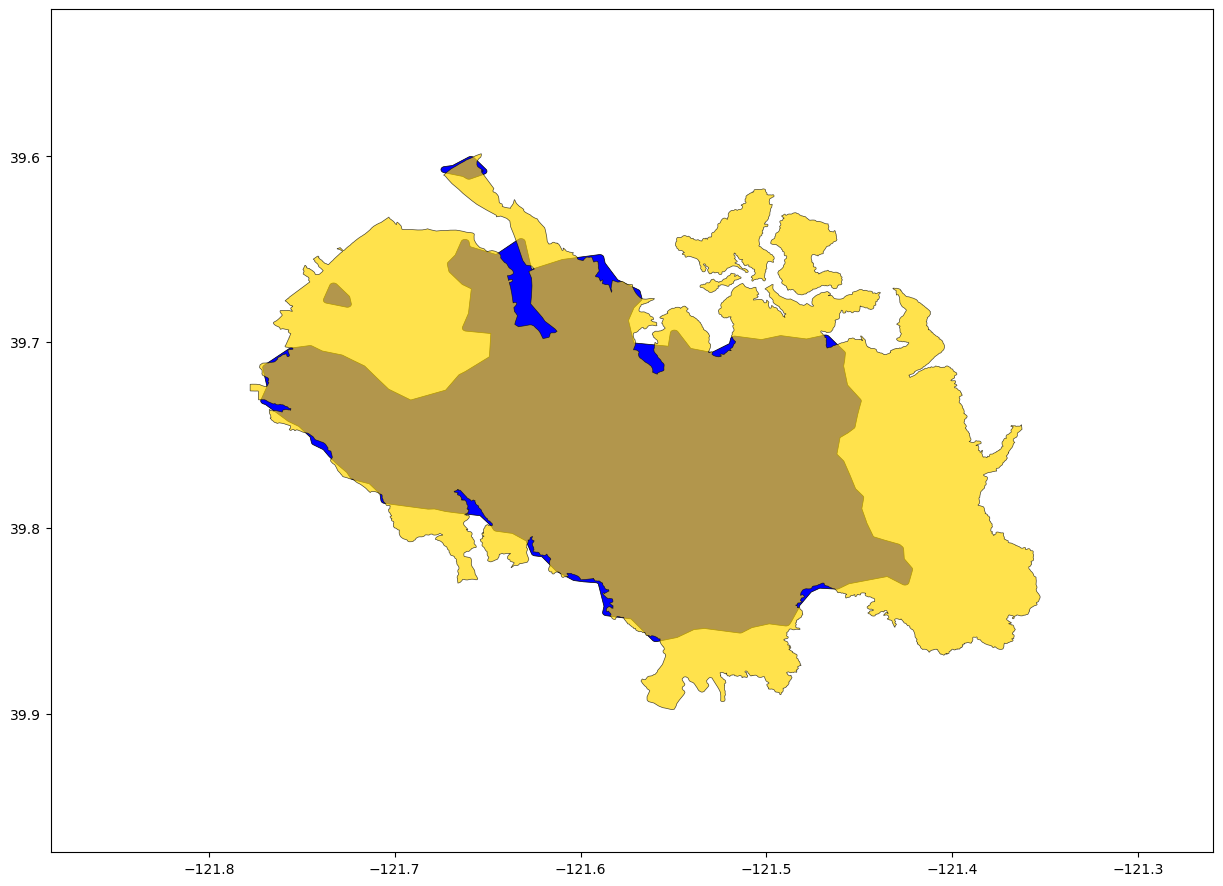

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))

# bound box as defined by us
ax.set_xlim(-121.885171, -121.259433)
ax.set_ylim(39.974603, 39.520818)

# veda_kincade.t.values[0]

veda_camp = veda_firenrt.polygons[veda_firenrt.polygons['index'] == 32] # <-- thats the index in (41, 11287)! 
nifc_match = nifc_search.polygons[nifc_search.polygons['index'] == 11110] # <-- thats the index in (41, 11287)! 

# plot search results/what calculation is pulling from
v = veda_camp.plot(ax=ax, legend=True, label="VEDA Camp Fire Estimate", color="blue",edgecolor="black", linewidth=0.5 )
n = nifc_match.plot(ax=ax, legend=True, label="NIFC Nearest Date + Intersection", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
